## Imports:

In [1]:
import torch 
import unidecode
import random
import numpy as np
import matplotlib.pyplot as plt

from models.charRNN import make_charRNN, get_random_batch, generate
from utils import n_chars, check_validity, check_novelty, strsmis2listsmis, list2txt, get_props

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data preparation

In [3]:
file = unidecode.unidecode(open('all_data/s_100_str_+1M.txt').read())

In [4]:
file[0:100]

'<COc1ccc2[C@@H]3[C@H](COc2c1)C(C)(C)OC4=C3C(=O)C(=O)C5=C4OC(C)(C)[C@@H]6COc7cc(OC)ccc7[C@H]56><C[S+]'

## Make the model

In [5]:
lr = 0.0005

In [6]:
model_name = 'G'
rnn, optimizer, criterion = make_charRNN(n_chars=56, hidden_size=512, num_layers=3,
                                        lr=lr, pretrained_file=model_name) 

In [7]:
print(rnn)

RNN(
  (embed): Embedding(56, 30)
  (gru): GRU(30, 512, num_layers=3, batch_first=True)
  (fc): Linear(in_features=512, out_features=56, bias=True)
)


# Train

In [8]:
 obj='_2_'

In [9]:
def train(iters=10, chunk_len=256, n_epochs=800, print_every=10):
    print("=> Starting training...")
    Ls = []
    best_model = 'models/pretrained/CRLV_' +obj+str(lr)+'_'+str(n_epochs)+'_'+str(iters)+'_'+str(chunk_len)+ '_.pth'
    prev_best_loss = 1000000
    for epoch in range(1, n_epochs + 1):            
        inp, target = get_random_batch(file, chunk_len)
        hidden = rnn.init_hidden()

        rnn.zero_grad()
        loss = 0
        inp = inp.to(device)
        target = target.to(device)
        
        for i in range(chunk_len): 
            output, hidden = rnn(inp[:, i], hidden)
            loss += criterion(output, target[:,i])

#-------- the following lines are for conditional loss ---------------: 
        n = 1
        for i in range(iters):
            smi = generate(rnn, initial_str='<', predict_len=102, temperature=0.50)
            arr, alr, oh, cooh, coor, nh2, rval = get_props(smi, c=2) 
            cycle, grp, rv = 0, 0, 0 
            if arr==2 or alr==1: 
                cycle = 1
            if oh>=1 or cooh>=1 or coor>=1 or nh2>=1:
                grp = 1
            if 0.05<rval<0.5:
                rv = 1           
        
            if cycle==1 and grp==1 and rv==1:
                n = n*2
            
        loss = loss / n
#---------------------------------------------------------------------------------------
        loss.backward()
        optimizer.step()
        loss = loss.item()/(chunk_len)
        
        torch.save(rnn.state_dict(), best_model)        # save for each epoch
        
#         if prev_best_loss > loss:                     # or save for each improvment
#             prev_best_loss = loss
#             torch.save(rnn.state_dict(), best_model)
        
        Ls.append(loss)
        if epoch % print_every == 0:  
            print(f'Loss: {loss} epoch: {epoch}')           
    return Ls

In [10]:
## --- for reproducibility of the results ---
seeds = [3, 0, 3]

torch.manual_seed(seeds[0])
np.random.seed(seeds[1])
random.seed(seeds[2])

In [11]:
iters=20  
chunk_len=128  #128 or 256
n_epochs = 800

Losses = train(iters=iters, chunk_len=chunk_len, n_epochs=n_epochs, print_every=10)

=> Starting training...
Loss: 0.19801722466945648 epoch: 10
Loss: 0.9871942400932312 epoch: 20
Loss: 0.13815265893936157 epoch: 30
Loss: 1.2379142045974731 epoch: 40
Loss: 0.25452619791030884 epoch: 50
Loss: 0.07859731465578079 epoch: 60
Loss: 0.3104579448699951 epoch: 70
Loss: 0.45842647552490234 epoch: 80
Loss: 0.4690481126308441 epoch: 90
Loss: 0.09340375661849976 epoch: 100
Loss: 0.052691683173179626 epoch: 110
Loss: 0.030406823381781578 epoch: 120
Loss: 0.14149212837219238 epoch: 130
Loss: 0.6523196697235107 epoch: 140
Loss: 0.5033499002456665 epoch: 150
Loss: 0.2140752226114273 epoch: 160
Loss: 0.28920578956604004 epoch: 170
Loss: 0.9255890250205994 epoch: 180
Loss: 0.17764681577682495 epoch: 190
Loss: 0.569071352481842 epoch: 200
Loss: 0.46057194471359253 epoch: 210
Loss: 0.46194708347320557 epoch: 220
Loss: 0.6061777472496033 epoch: 230
Loss: 0.20277062058448792 epoch: 240
Loss: 0.2981194853782654 epoch: 250
Loss: 0.4376928210258484 epoch: 260
Loss: 0.2707723379135132 epoch: 27

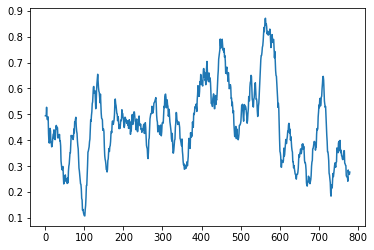

In [12]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

Losses_ = moving_average(Losses, 20)
plt.plot(Losses_)

## 0. generate:

In [7]:
# get the model saved during traiing (the best)
# model_name = 'CRLV_'+obj+str(lr)+'_'+str(n_epochs)+'_'+str(iters)+'_'+str(chunk_len)+ '_'   #or use the provided one
model_name = 'CRLV_2' 
rnn, optimizer, criterion = make_charRNN(n_chars=56, hidden_size=512, num_layers=3,
                                        lr=lr, pretrained_file=model_name) 
print(model_name)

CRLV_2


In [13]:
CLF_temp = 0.5 

In [14]:
n_ep = 10000
all_smis = []
for ep in range(n_ep):
    length = 102 
    ic = '<'
    smi = generate(rnn, initial_str=ic, predict_len=length, temperature=CLF_temp)
    all_smis.append(smi)
    print("iteration:", ep)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

iteration: 554
iteration: 555
iteration: 556
iteration: 557
iteration: 558
iteration: 559
iteration: 560
iteration: 561
iteration: 562
iteration: 563
iteration: 564
iteration: 565
iteration: 566
iteration: 567
iteration: 568
iteration: 569
iteration: 570
iteration: 571
iteration: 572
iteration: 573
iteration: 574
iteration: 575
iteration: 576
iteration: 577
iteration: 578
iteration: 579
iteration: 580
iteration: 581
iteration: 582
iteration: 583
iteration: 584
iteration: 585
iteration: 586
iteration: 587
iteration: 588
iteration: 589
iteration: 590
iteration: 591
iteration: 592
iteration: 593
iteration: 594
iteration: 595
iteration: 596
iteration: 597
iteration: 598
iteration: 599
iteration: 600
iteration: 601
iteration: 602
iteration: 603
iteration: 604
iteration: 605
iteration: 606
iteration: 607
iteration: 608
iteration: 609
iteration: 610
iteration: 611
iteration: 612
iteration: 613
iteration: 614
iteration: 615
iteration: 616
iteration: 617
iteration: 618
iteration: 619
iteration:

iteration: 1094
iteration: 1095
iteration: 1096
iteration: 1097
iteration: 1098
iteration: 1099
iteration: 1100
iteration: 1101
iteration: 1102
iteration: 1103
iteration: 1104
iteration: 1105
iteration: 1106
iteration: 1107
iteration: 1108
iteration: 1109
iteration: 1110
iteration: 1111
iteration: 1112
iteration: 1113
iteration: 1114
iteration: 1115
iteration: 1116
iteration: 1117
iteration: 1118
iteration: 1119
iteration: 1120
iteration: 1121
iteration: 1122
iteration: 1123
iteration: 1124
iteration: 1125
iteration: 1126
iteration: 1127
iteration: 1128
iteration: 1129
iteration: 1130
iteration: 1131
iteration: 1132
iteration: 1133
iteration: 1134
iteration: 1135
iteration: 1136
iteration: 1137
iteration: 1138
iteration: 1139
iteration: 1140
iteration: 1141
iteration: 1142
iteration: 1143
iteration: 1144
iteration: 1145
iteration: 1146
iteration: 1147
iteration: 1148
iteration: 1149
iteration: 1150
iteration: 1151
iteration: 1152
iteration: 1153
iteration: 1154
iteration: 1155
iteratio

iteration: 1607
iteration: 1608
iteration: 1609
iteration: 1610
iteration: 1611
iteration: 1612
iteration: 1613
iteration: 1614
iteration: 1615
iteration: 1616
iteration: 1617
iteration: 1618
iteration: 1619
iteration: 1620
iteration: 1621
iteration: 1622
iteration: 1623
iteration: 1624
iteration: 1625
iteration: 1626
iteration: 1627
iteration: 1628
iteration: 1629
iteration: 1630
iteration: 1631
iteration: 1632
iteration: 1633
iteration: 1634
iteration: 1635
iteration: 1636
iteration: 1637
iteration: 1638
iteration: 1639
iteration: 1640
iteration: 1641
iteration: 1642
iteration: 1643
iteration: 1644
iteration: 1645
iteration: 1646
iteration: 1647
iteration: 1648
iteration: 1649
iteration: 1650
iteration: 1651
iteration: 1652
iteration: 1653
iteration: 1654
iteration: 1655
iteration: 1656
iteration: 1657
iteration: 1658
iteration: 1659
iteration: 1660
iteration: 1661
iteration: 1662
iteration: 1663
iteration: 1664
iteration: 1665
iteration: 1666
iteration: 1667
iteration: 1668
iteratio

iteration: 2121
iteration: 2122
iteration: 2123
iteration: 2124
iteration: 2125
iteration: 2126
iteration: 2127
iteration: 2128
iteration: 2129
iteration: 2130
iteration: 2131
iteration: 2132
iteration: 2133
iteration: 2134
iteration: 2135
iteration: 2136
iteration: 2137
iteration: 2138
iteration: 2139
iteration: 2140
iteration: 2141
iteration: 2142
iteration: 2143
iteration: 2144
iteration: 2145
iteration: 2146
iteration: 2147
iteration: 2148
iteration: 2149
iteration: 2150
iteration: 2151
iteration: 2152
iteration: 2153
iteration: 2154
iteration: 2155
iteration: 2156
iteration: 2157
iteration: 2158
iteration: 2159
iteration: 2160
iteration: 2161
iteration: 2162
iteration: 2163
iteration: 2164
iteration: 2165
iteration: 2166
iteration: 2167
iteration: 2168
iteration: 2169
iteration: 2170
iteration: 2171
iteration: 2172
iteration: 2173
iteration: 2174
iteration: 2175
iteration: 2176
iteration: 2177
iteration: 2178
iteration: 2179
iteration: 2180
iteration: 2181
iteration: 2182
iteratio

iteration: 2636
iteration: 2637
iteration: 2638
iteration: 2639
iteration: 2640
iteration: 2641
iteration: 2642
iteration: 2643
iteration: 2644
iteration: 2645
iteration: 2646
iteration: 2647
iteration: 2648
iteration: 2649
iteration: 2650
iteration: 2651
iteration: 2652
iteration: 2653
iteration: 2654
iteration: 2655
iteration: 2656
iteration: 2657
iteration: 2658
iteration: 2659
iteration: 2660
iteration: 2661
iteration: 2662
iteration: 2663
iteration: 2664
iteration: 2665
iteration: 2666
iteration: 2667
iteration: 2668
iteration: 2669
iteration: 2670
iteration: 2671
iteration: 2672
iteration: 2673
iteration: 2674
iteration: 2675
iteration: 2676
iteration: 2677
iteration: 2678
iteration: 2679
iteration: 2680
iteration: 2681
iteration: 2682
iteration: 2683
iteration: 2684
iteration: 2685
iteration: 2686
iteration: 2687
iteration: 2688
iteration: 2689
iteration: 2690
iteration: 2691
iteration: 2692
iteration: 2693
iteration: 2694
iteration: 2695
iteration: 2696
iteration: 2697
iteratio

iteration: 3150
iteration: 3151
iteration: 3152
iteration: 3153
iteration: 3154
iteration: 3155
iteration: 3156
iteration: 3157
iteration: 3158
iteration: 3159
iteration: 3160
iteration: 3161
iteration: 3162
iteration: 3163
iteration: 3164
iteration: 3165
iteration: 3166
iteration: 3167
iteration: 3168
iteration: 3169
iteration: 3170
iteration: 3171
iteration: 3172
iteration: 3173
iteration: 3174
iteration: 3175
iteration: 3176
iteration: 3177
iteration: 3178
iteration: 3179
iteration: 3180
iteration: 3181
iteration: 3182
iteration: 3183
iteration: 3184
iteration: 3185
iteration: 3186
iteration: 3187
iteration: 3188
iteration: 3189
iteration: 3190
iteration: 3191
iteration: 3192
iteration: 3193
iteration: 3194
iteration: 3195
iteration: 3196
iteration: 3197
iteration: 3198
iteration: 3199
iteration: 3200
iteration: 3201
iteration: 3202
iteration: 3203
iteration: 3204
iteration: 3205
iteration: 3206
iteration: 3207
iteration: 3208
iteration: 3209
iteration: 3210
iteration: 3211
iteratio

iteration: 3664
iteration: 3665
iteration: 3666
iteration: 3667
iteration: 3668
iteration: 3669
iteration: 3670
iteration: 3671
iteration: 3672
iteration: 3673
iteration: 3674
iteration: 3675
iteration: 3676
iteration: 3677
iteration: 3678
iteration: 3679
iteration: 3680
iteration: 3681
iteration: 3682
iteration: 3683
iteration: 3684
iteration: 3685
iteration: 3686
iteration: 3687
iteration: 3688
iteration: 3689
iteration: 3690
iteration: 3691
iteration: 3692
iteration: 3693
iteration: 3694
iteration: 3695
iteration: 3696
iteration: 3697
iteration: 3698
iteration: 3699
iteration: 3700
iteration: 3701
iteration: 3702
iteration: 3703
iteration: 3704
iteration: 3705
iteration: 3706
iteration: 3707
iteration: 3708
iteration: 3709
iteration: 3710
iteration: 3711
iteration: 3712
iteration: 3713
iteration: 3714
iteration: 3715
iteration: 3716
iteration: 3717
iteration: 3718
iteration: 3719
iteration: 3720
iteration: 3721
iteration: 3722
iteration: 3723
iteration: 3724
iteration: 3725
iteratio

iteration: 4178
iteration: 4179
iteration: 4180
iteration: 4181
iteration: 4182
iteration: 4183
iteration: 4184
iteration: 4185
iteration: 4186
iteration: 4187
iteration: 4188
iteration: 4189
iteration: 4190
iteration: 4191
iteration: 4192
iteration: 4193
iteration: 4194
iteration: 4195
iteration: 4196
iteration: 4197
iteration: 4198
iteration: 4199
iteration: 4200
iteration: 4201
iteration: 4202
iteration: 4203
iteration: 4204
iteration: 4205
iteration: 4206
iteration: 4207
iteration: 4208
iteration: 4209
iteration: 4210
iteration: 4211
iteration: 4212
iteration: 4213
iteration: 4214
iteration: 4215
iteration: 4216
iteration: 4217
iteration: 4218
iteration: 4219
iteration: 4220
iteration: 4221
iteration: 4222
iteration: 4223
iteration: 4224
iteration: 4225
iteration: 4226
iteration: 4227
iteration: 4228
iteration: 4229
iteration: 4230
iteration: 4231
iteration: 4232
iteration: 4233
iteration: 4234
iteration: 4235
iteration: 4236
iteration: 4237
iteration: 4238
iteration: 4239
iteratio

iteration: 4692
iteration: 4693
iteration: 4694
iteration: 4695
iteration: 4696
iteration: 4697
iteration: 4698
iteration: 4699
iteration: 4700
iteration: 4701
iteration: 4702
iteration: 4703
iteration: 4704
iteration: 4705
iteration: 4706
iteration: 4707
iteration: 4708
iteration: 4709
iteration: 4710
iteration: 4711
iteration: 4712
iteration: 4713
iteration: 4714
iteration: 4715
iteration: 4716
iteration: 4717
iteration: 4718
iteration: 4719
iteration: 4720
iteration: 4721
iteration: 4722
iteration: 4723
iteration: 4724
iteration: 4725
iteration: 4726
iteration: 4727
iteration: 4728
iteration: 4729
iteration: 4730
iteration: 4731
iteration: 4732
iteration: 4733
iteration: 4734
iteration: 4735
iteration: 4736
iteration: 4737
iteration: 4738
iteration: 4739
iteration: 4740
iteration: 4741
iteration: 4742
iteration: 4743
iteration: 4744
iteration: 4745
iteration: 4746
iteration: 4747
iteration: 4748
iteration: 4749
iteration: 4750
iteration: 4751
iteration: 4752
iteration: 4753
iteratio

iteration: 5206
iteration: 5207
iteration: 5208
iteration: 5209
iteration: 5210
iteration: 5211
iteration: 5212
iteration: 5213
iteration: 5214
iteration: 5215
iteration: 5216
iteration: 5217
iteration: 5218
iteration: 5219
iteration: 5220
iteration: 5221
iteration: 5222
iteration: 5223
iteration: 5224
iteration: 5225
iteration: 5226
iteration: 5227
iteration: 5228
iteration: 5229
iteration: 5230
iteration: 5231
iteration: 5232
iteration: 5233
iteration: 5234
iteration: 5235
iteration: 5236
iteration: 5237
iteration: 5238
iteration: 5239
iteration: 5240
iteration: 5241
iteration: 5242
iteration: 5243
iteration: 5244
iteration: 5245
iteration: 5246
iteration: 5247
iteration: 5248
iteration: 5249
iteration: 5250
iteration: 5251
iteration: 5252
iteration: 5253
iteration: 5254
iteration: 5255
iteration: 5256
iteration: 5257
iteration: 5258
iteration: 5259
iteration: 5260
iteration: 5261
iteration: 5262
iteration: 5263
iteration: 5264
iteration: 5265
iteration: 5266
iteration: 5267
iteratio

iteration: 5721
iteration: 5722
iteration: 5723
iteration: 5724
iteration: 5725
iteration: 5726
iteration: 5727
iteration: 5728
iteration: 5729
iteration: 5730
iteration: 5731
iteration: 5732
iteration: 5733
iteration: 5734
iteration: 5735
iteration: 5736
iteration: 5737
iteration: 5738
iteration: 5739
iteration: 5740
iteration: 5741
iteration: 5742
iteration: 5743
iteration: 5744
iteration: 5745
iteration: 5746
iteration: 5747
iteration: 5748
iteration: 5749
iteration: 5750
iteration: 5751
iteration: 5752
iteration: 5753
iteration: 5754
iteration: 5755
iteration: 5756
iteration: 5757
iteration: 5758
iteration: 5759
iteration: 5760
iteration: 5761
iteration: 5762
iteration: 5763
iteration: 5764
iteration: 5765
iteration: 5766
iteration: 5767
iteration: 5768
iteration: 5769
iteration: 5770
iteration: 5771
iteration: 5772
iteration: 5773
iteration: 5774
iteration: 5775
iteration: 5776
iteration: 5777
iteration: 5778
iteration: 5779
iteration: 5780
iteration: 5781
iteration: 5782
iteratio

iteration: 6234
iteration: 6235
iteration: 6236
iteration: 6237
iteration: 6238
iteration: 6239
iteration: 6240
iteration: 6241
iteration: 6242
iteration: 6243
iteration: 6244
iteration: 6245
iteration: 6246
iteration: 6247
iteration: 6248
iteration: 6249
iteration: 6250
iteration: 6251
iteration: 6252
iteration: 6253
iteration: 6254
iteration: 6255
iteration: 6256
iteration: 6257
iteration: 6258
iteration: 6259
iteration: 6260
iteration: 6261
iteration: 6262
iteration: 6263
iteration: 6264
iteration: 6265
iteration: 6266
iteration: 6267
iteration: 6268
iteration: 6269
iteration: 6270
iteration: 6271
iteration: 6272
iteration: 6273
iteration: 6274
iteration: 6275
iteration: 6276
iteration: 6277
iteration: 6278
iteration: 6279
iteration: 6280
iteration: 6281
iteration: 6282
iteration: 6283
iteration: 6284
iteration: 6285
iteration: 6286
iteration: 6287
iteration: 6288
iteration: 6289
iteration: 6290
iteration: 6291
iteration: 6292
iteration: 6293
iteration: 6294
iteration: 6295
iteratio

iteration: 6748
iteration: 6749
iteration: 6750
iteration: 6751
iteration: 6752
iteration: 6753
iteration: 6754
iteration: 6755
iteration: 6756
iteration: 6757
iteration: 6758
iteration: 6759
iteration: 6760
iteration: 6761
iteration: 6762
iteration: 6763
iteration: 6764
iteration: 6765
iteration: 6766
iteration: 6767
iteration: 6768
iteration: 6769
iteration: 6770
iteration: 6771
iteration: 6772
iteration: 6773
iteration: 6774
iteration: 6775
iteration: 6776
iteration: 6777
iteration: 6778
iteration: 6779
iteration: 6780
iteration: 6781
iteration: 6782
iteration: 6783
iteration: 6784
iteration: 6785
iteration: 6786
iteration: 6787
iteration: 6788
iteration: 6789
iteration: 6790
iteration: 6791
iteration: 6792
iteration: 6793
iteration: 6794
iteration: 6795
iteration: 6796
iteration: 6797
iteration: 6798
iteration: 6799
iteration: 6800
iteration: 6801
iteration: 6802
iteration: 6803
iteration: 6804
iteration: 6805
iteration: 6806
iteration: 6807
iteration: 6808
iteration: 6809
iteratio

iteration: 7262
iteration: 7263
iteration: 7264
iteration: 7265
iteration: 7266
iteration: 7267
iteration: 7268
iteration: 7269
iteration: 7270
iteration: 7271
iteration: 7272
iteration: 7273
iteration: 7274
iteration: 7275
iteration: 7276
iteration: 7277
iteration: 7278
iteration: 7279
iteration: 7280
iteration: 7281
iteration: 7282
iteration: 7283
iteration: 7284
iteration: 7285
iteration: 7286
iteration: 7287
iteration: 7288
iteration: 7289
iteration: 7290
iteration: 7291
iteration: 7292
iteration: 7293
iteration: 7294
iteration: 7295
iteration: 7296
iteration: 7297
iteration: 7298
iteration: 7299
iteration: 7300
iteration: 7301
iteration: 7302
iteration: 7303
iteration: 7304
iteration: 7305
iteration: 7306
iteration: 7307
iteration: 7308
iteration: 7309
iteration: 7310
iteration: 7311
iteration: 7312
iteration: 7313
iteration: 7314
iteration: 7315
iteration: 7316
iteration: 7317
iteration: 7318
iteration: 7319
iteration: 7320
iteration: 7321
iteration: 7322
iteration: 7323
iteratio

iteration: 7776
iteration: 7777
iteration: 7778
iteration: 7779
iteration: 7780
iteration: 7781
iteration: 7782
iteration: 7783
iteration: 7784
iteration: 7785
iteration: 7786
iteration: 7787
iteration: 7788
iteration: 7789
iteration: 7790
iteration: 7791
iteration: 7792
iteration: 7793
iteration: 7794
iteration: 7795
iteration: 7796
iteration: 7797
iteration: 7798
iteration: 7799
iteration: 7800
iteration: 7801
iteration: 7802
iteration: 7803
iteration: 7804
iteration: 7805
iteration: 7806
iteration: 7807
iteration: 7808
iteration: 7809
iteration: 7810
iteration: 7811
iteration: 7812
iteration: 7813
iteration: 7814
iteration: 7815
iteration: 7816
iteration: 7817
iteration: 7818
iteration: 7819
iteration: 7820
iteration: 7821
iteration: 7822
iteration: 7823
iteration: 7824
iteration: 7825
iteration: 7826
iteration: 7827
iteration: 7828
iteration: 7829
iteration: 7830
iteration: 7831
iteration: 7832
iteration: 7833
iteration: 7834
iteration: 7835
iteration: 7836
iteration: 7837
iteratio

iteration: 8290
iteration: 8291
iteration: 8292
iteration: 8293
iteration: 8294
iteration: 8295
iteration: 8296
iteration: 8297
iteration: 8298
iteration: 8299
iteration: 8300
iteration: 8301
iteration: 8302
iteration: 8303
iteration: 8304
iteration: 8305
iteration: 8306
iteration: 8307
iteration: 8308
iteration: 8309
iteration: 8310
iteration: 8311
iteration: 8312
iteration: 8313
iteration: 8314
iteration: 8315
iteration: 8316
iteration: 8317
iteration: 8318
iteration: 8319
iteration: 8320
iteration: 8321
iteration: 8322
iteration: 8323
iteration: 8324
iteration: 8325
iteration: 8326
iteration: 8327
iteration: 8328
iteration: 8329
iteration: 8330
iteration: 8331
iteration: 8332
iteration: 8333
iteration: 8334
iteration: 8335
iteration: 8336
iteration: 8337
iteration: 8338
iteration: 8339
iteration: 8340
iteration: 8341
iteration: 8342
iteration: 8343
iteration: 8344
iteration: 8345
iteration: 8346
iteration: 8347
iteration: 8348
iteration: 8349
iteration: 8350
iteration: 8351
iteratio

iteration: 8804
iteration: 8805
iteration: 8806
iteration: 8807
iteration: 8808
iteration: 8809
iteration: 8810
iteration: 8811
iteration: 8812
iteration: 8813
iteration: 8814
iteration: 8815
iteration: 8816
iteration: 8817
iteration: 8818
iteration: 8819
iteration: 8820
iteration: 8821
iteration: 8822
iteration: 8823
iteration: 8824
iteration: 8825
iteration: 8826
iteration: 8827
iteration: 8828
iteration: 8829
iteration: 8830
iteration: 8831
iteration: 8832
iteration: 8833
iteration: 8834
iteration: 8835
iteration: 8836
iteration: 8837
iteration: 8838
iteration: 8839
iteration: 8840
iteration: 8841
iteration: 8842
iteration: 8843
iteration: 8844
iteration: 8845
iteration: 8846
iteration: 8847
iteration: 8848
iteration: 8849
iteration: 8850
iteration: 8851
iteration: 8852
iteration: 8853
iteration: 8854
iteration: 8855
iteration: 8856
iteration: 8857
iteration: 8858
iteration: 8859
iteration: 8860
iteration: 8861
iteration: 8862
iteration: 8863
iteration: 8864
iteration: 8865
iteratio

iteration: 9318
iteration: 9319
iteration: 9320
iteration: 9321
iteration: 9322
iteration: 9323
iteration: 9324
iteration: 9325
iteration: 9326
iteration: 9327
iteration: 9328
iteration: 9329
iteration: 9330
iteration: 9331
iteration: 9332
iteration: 9333
iteration: 9334
iteration: 9335
iteration: 9336
iteration: 9337
iteration: 9338
iteration: 9339
iteration: 9340
iteration: 9341
iteration: 9342
iteration: 9343
iteration: 9344
iteration: 9345
iteration: 9346
iteration: 9347
iteration: 9348
iteration: 9349
iteration: 9350
iteration: 9351
iteration: 9352
iteration: 9353
iteration: 9354
iteration: 9355
iteration: 9356
iteration: 9357
iteration: 9358
iteration: 9359
iteration: 9360
iteration: 9361
iteration: 9362
iteration: 9363
iteration: 9364
iteration: 9365
iteration: 9366
iteration: 9367
iteration: 9368
iteration: 9369
iteration: 9370
iteration: 9371
iteration: 9372
iteration: 9373
iteration: 9374
iteration: 9375
iteration: 9376
iteration: 9377
iteration: 9378
iteration: 9379
iteratio

iteration: 9831
iteration: 9832
iteration: 9833
iteration: 9834
iteration: 9835
iteration: 9836
iteration: 9837
iteration: 9838
iteration: 9839
iteration: 9840
iteration: 9841
iteration: 9842
iteration: 9843
iteration: 9844
iteration: 9845
iteration: 9846
iteration: 9847
iteration: 9848
iteration: 9849
iteration: 9850
iteration: 9851
iteration: 9852
iteration: 9853
iteration: 9854
iteration: 9855
iteration: 9856
iteration: 9857
iteration: 9858
iteration: 9859
iteration: 9860
iteration: 9861
iteration: 9862
iteration: 9863
iteration: 9864
iteration: 9865
iteration: 9866
iteration: 9867
iteration: 9868
iteration: 9869
iteration: 9870
iteration: 9871
iteration: 9872
iteration: 9873
iteration: 9874
iteration: 9875
iteration: 9876
iteration: 9877
iteration: 9878
iteration: 9879
iteration: 9880
iteration: 9881
iteration: 9882
iteration: 9883
iteration: 9884
iteration: 9885
iteration: 9886
iteration: 9887
iteration: 9888
iteration: 9889
iteration: 9890
iteration: 9891
iteration: 9892
iteratio

In [24]:
### save the list of generated smiles if you want
# filename = model_name + '_all_smis_.txt'
# path = 'gen_smis/' + filename
# list2txt(path, mylist=all_smis)

## 1. How many among all_smis are valid:

In [15]:
val_smis = []
for i, s in enumerate(all_smis):
    v = check_validity(s)
    if v == 1:
        val_smis.append(s)
        print("mol at:", i, " : verified")

mol at: 0  : verified
mol at: 1  : verified
mol at: 3  : verified
mol at: 4  : verified
mol at: 5  : verified
mol at: 6  : verified
mol at: 7  : verified
mol at: 11  : verified
mol at: 12  : verified
mol at: 13  : verified
mol at: 14  : verified
mol at: 15  : verified
mol at: 16  : verified
mol at: 18  : verified
mol at: 20  : verified
mol at: 22  : verified
mol at: 23  : verified
mol at: 25  : verified
mol at: 26  : verified
mol at: 32  : verified
mol at: 33  : verified
mol at: 34  : verified
mol at: 36  : verified
mol at: 37  : verified
mol at: 39  : verified
mol at: 41  : verified
mol at: 44  : verified
mol at: 46  : verified
mol at: 50  : verified
mol at: 51  : verified
mol at: 55  : verified
mol at: 56  : verified
mol at: 59  : verified
mol at: 60  : verified
mol at: 63  : verified
mol at: 68  : verified
mol at: 69  : verified
mol at: 70  : verified
mol at: 71  : verified
mol at: 73  : verified
mol at: 75  : verified
mol at: 77  : verified
mol at: 78  : verified
mol at: 79  : veri

mol at: 703  : verified
mol at: 704  : verified
mol at: 705  : verified
mol at: 706  : verified
mol at: 707  : verified
mol at: 710  : verified
mol at: 711  : verified
mol at: 713  : verified
mol at: 714  : verified
mol at: 715  : verified
mol at: 717  : verified
mol at: 718  : verified
mol at: 719  : verified
mol at: 720  : verified
mol at: 721  : verified
mol at: 723  : verified
mol at: 724  : verified
mol at: 726  : verified
mol at: 728  : verified
mol at: 729  : verified
mol at: 733  : verified
mol at: 734  : verified
mol at: 735  : verified
mol at: 736  : verified
mol at: 738  : verified
mol at: 739  : verified
mol at: 743  : verified
mol at: 746  : verified
mol at: 747  : verified
mol at: 748  : verified
mol at: 749  : verified
mol at: 750  : verified
mol at: 751  : verified
mol at: 752  : verified
mol at: 754  : verified
mol at: 756  : verified
mol at: 760  : verified
mol at: 761  : verified
mol at: 763  : verified
mol at: 764  : verified
mol at: 766  : verified
mol at: 768  : v

mol at: 1382  : verified
mol at: 1383  : verified
mol at: 1384  : verified
mol at: 1385  : verified
mol at: 1387  : verified
mol at: 1390  : verified
mol at: 1391  : verified
mol at: 1394  : verified
mol at: 1395  : verified
mol at: 1398  : verified
mol at: 1400  : verified
mol at: 1401  : verified
mol at: 1404  : verified
mol at: 1405  : verified
mol at: 1406  : verified
mol at: 1407  : verified
mol at: 1413  : verified
mol at: 1416  : verified
mol at: 1417  : verified
mol at: 1418  : verified
mol at: 1419  : verified
mol at: 1421  : verified
mol at: 1425  : verified
mol at: 1426  : verified
mol at: 1427  : verified
mol at: 1429  : verified
mol at: 1433  : verified
mol at: 1434  : verified
mol at: 1435  : verified
mol at: 1436  : verified
mol at: 1442  : verified
mol at: 1443  : verified
mol at: 1444  : verified
mol at: 1445  : verified
mol at: 1446  : verified
mol at: 1447  : verified
mol at: 1448  : verified
mol at: 1450  : verified
mol at: 1453  : verified
mol at: 1454  : verified


mol at: 2130  : verified
mol at: 2132  : verified
mol at: 2135  : verified
mol at: 2136  : verified
mol at: 2141  : verified
mol at: 2144  : verified
mol at: 2145  : verified
mol at: 2147  : verified
mol at: 2149  : verified
mol at: 2150  : verified
mol at: 2151  : verified
mol at: 2153  : verified
mol at: 2156  : verified
mol at: 2158  : verified
mol at: 2159  : verified
mol at: 2160  : verified
mol at: 2161  : verified
mol at: 2163  : verified
mol at: 2168  : verified
mol at: 2169  : verified
mol at: 2170  : verified
mol at: 2172  : verified
mol at: 2173  : verified
mol at: 2174  : verified
mol at: 2175  : verified
mol at: 2176  : verified
mol at: 2177  : verified
mol at: 2179  : verified
mol at: 2180  : verified
mol at: 2181  : verified
mol at: 2188  : verified
mol at: 2189  : verified
mol at: 2191  : verified
mol at: 2194  : verified
mol at: 2195  : verified
mol at: 2196  : verified
mol at: 2197  : verified
mol at: 2199  : verified
mol at: 2202  : verified
mol at: 2203  : verified


mol at: 2757  : verified
mol at: 2758  : verified
mol at: 2759  : verified
mol at: 2762  : verified
mol at: 2763  : verified
mol at: 2764  : verified
mol at: 2765  : verified
mol at: 2766  : verified
mol at: 2767  : verified
mol at: 2768  : verified
mol at: 2772  : verified
mol at: 2774  : verified
mol at: 2779  : verified
mol at: 2781  : verified
mol at: 2782  : verified
mol at: 2783  : verified
mol at: 2784  : verified
mol at: 2786  : verified
mol at: 2787  : verified
mol at: 2788  : verified
mol at: 2789  : verified
mol at: 2790  : verified
mol at: 2791  : verified
mol at: 2793  : verified
mol at: 2794  : verified
mol at: 2795  : verified
mol at: 2799  : verified
mol at: 2800  : verified
mol at: 2801  : verified
mol at: 2803  : verified
mol at: 2804  : verified
mol at: 2805  : verified
mol at: 2806  : verified
mol at: 2807  : verified
mol at: 2809  : verified
mol at: 2812  : verified
mol at: 2813  : verified
mol at: 2814  : verified
mol at: 2816  : verified
mol at: 2817  : verified


mol at: 3377  : verified
mol at: 3378  : verified
mol at: 3379  : verified
mol at: 3380  : verified
mol at: 3381  : verified
mol at: 3382  : verified
mol at: 3383  : verified
mol at: 3388  : verified
mol at: 3392  : verified
mol at: 3393  : verified
mol at: 3397  : verified
mol at: 3401  : verified
mol at: 3403  : verified
mol at: 3405  : verified
mol at: 3406  : verified
mol at: 3407  : verified
mol at: 3410  : verified
mol at: 3413  : verified
mol at: 3415  : verified
mol at: 3421  : verified
mol at: 3423  : verified
mol at: 3424  : verified
mol at: 3427  : verified
mol at: 3428  : verified
mol at: 3429  : verified
mol at: 3430  : verified
mol at: 3431  : verified
mol at: 3432  : verified
mol at: 3434  : verified
mol at: 3435  : verified
mol at: 3436  : verified
mol at: 3438  : verified
mol at: 3445  : verified
mol at: 3446  : verified
mol at: 3447  : verified
mol at: 3448  : verified
mol at: 3449  : verified
mol at: 3451  : verified
mol at: 3453  : verified
mol at: 3455  : verified


mol at: 4031  : verified
mol at: 4035  : verified
mol at: 4036  : verified
mol at: 4037  : verified
mol at: 4039  : verified
mol at: 4042  : verified
mol at: 4045  : verified
mol at: 4047  : verified
mol at: 4049  : verified
mol at: 4053  : verified
mol at: 4054  : verified
mol at: 4055  : verified
mol at: 4059  : verified
mol at: 4061  : verified
mol at: 4062  : verified
mol at: 4063  : verified
mol at: 4064  : verified
mol at: 4065  : verified
mol at: 4066  : verified
mol at: 4068  : verified
mol at: 4070  : verified
mol at: 4071  : verified
mol at: 4072  : verified
mol at: 4073  : verified
mol at: 4076  : verified
mol at: 4077  : verified
mol at: 4078  : verified
mol at: 4079  : verified
mol at: 4080  : verified
mol at: 4082  : verified
mol at: 4083  : verified
mol at: 4084  : verified
mol at: 4086  : verified
mol at: 4087  : verified
mol at: 4088  : verified
mol at: 4090  : verified
mol at: 4091  : verified
mol at: 4092  : verified
mol at: 4093  : verified
mol at: 4095  : verified


mol at: 4801  : verified
mol at: 4803  : verified
mol at: 4804  : verified
mol at: 4805  : verified
mol at: 4806  : verified
mol at: 4807  : verified
mol at: 4813  : verified
mol at: 4814  : verified
mol at: 4818  : verified
mol at: 4820  : verified
mol at: 4821  : verified
mol at: 4822  : verified
mol at: 4823  : verified
mol at: 4830  : verified
mol at: 4832  : verified
mol at: 4834  : verified
mol at: 4836  : verified
mol at: 4837  : verified
mol at: 4841  : verified
mol at: 4842  : verified
mol at: 4843  : verified
mol at: 4844  : verified
mol at: 4845  : verified
mol at: 4846  : verified
mol at: 4847  : verified
mol at: 4850  : verified
mol at: 4852  : verified
mol at: 4853  : verified
mol at: 4855  : verified
mol at: 4857  : verified
mol at: 4859  : verified
mol at: 4860  : verified
mol at: 4861  : verified
mol at: 4865  : verified
mol at: 4869  : verified
mol at: 4870  : verified
mol at: 4873  : verified
mol at: 4877  : verified
mol at: 4880  : verified
mol at: 4881  : verified


mol at: 5446  : verified
mol at: 5447  : verified
mol at: 5451  : verified
mol at: 5458  : verified
mol at: 5461  : verified
mol at: 5462  : verified
mol at: 5465  : verified
mol at: 5466  : verified
mol at: 5467  : verified
mol at: 5468  : verified
mol at: 5469  : verified
mol at: 5470  : verified
mol at: 5471  : verified
mol at: 5472  : verified
mol at: 5473  : verified
mol at: 5476  : verified
mol at: 5477  : verified
mol at: 5480  : verified
mol at: 5482  : verified
mol at: 5483  : verified
mol at: 5485  : verified
mol at: 5486  : verified
mol at: 5488  : verified
mol at: 5489  : verified
mol at: 5490  : verified
mol at: 5493  : verified
mol at: 5494  : verified
mol at: 5496  : verified
mol at: 5497  : verified
mol at: 5499  : verified
mol at: 5500  : verified
mol at: 5502  : verified
mol at: 5504  : verified
mol at: 5505  : verified
mol at: 5506  : verified
mol at: 5507  : verified
mol at: 5508  : verified
mol at: 5513  : verified
mol at: 5514  : verified
mol at: 5516  : verified


mol at: 6188  : verified
mol at: 6191  : verified
mol at: 6192  : verified
mol at: 6195  : verified
mol at: 6198  : verified
mol at: 6200  : verified
mol at: 6202  : verified
mol at: 6205  : verified
mol at: 6206  : verified
mol at: 6207  : verified
mol at: 6209  : verified
mol at: 6212  : verified
mol at: 6213  : verified
mol at: 6215  : verified
mol at: 6216  : verified
mol at: 6217  : verified
mol at: 6219  : verified
mol at: 6221  : verified
mol at: 6222  : verified
mol at: 6223  : verified
mol at: 6225  : verified
mol at: 6226  : verified
mol at: 6227  : verified
mol at: 6230  : verified
mol at: 6231  : verified
mol at: 6233  : verified
mol at: 6234  : verified
mol at: 6235  : verified
mol at: 6237  : verified
mol at: 6239  : verified
mol at: 6242  : verified
mol at: 6243  : verified
mol at: 6245  : verified
mol at: 6247  : verified
mol at: 6248  : verified
mol at: 6250  : verified
mol at: 6251  : verified
mol at: 6252  : verified
mol at: 6253  : verified
mol at: 6254  : verified


mol at: 6841  : verified
mol at: 6842  : verified
mol at: 6843  : verified
mol at: 6845  : verified
mol at: 6846  : verified
mol at: 6848  : verified
mol at: 6849  : verified
mol at: 6850  : verified
mol at: 6851  : verified
mol at: 6853  : verified
mol at: 6854  : verified
mol at: 6855  : verified
mol at: 6856  : verified
mol at: 6858  : verified
mol at: 6863  : verified
mol at: 6864  : verified
mol at: 6865  : verified
mol at: 6866  : verified
mol at: 6867  : verified
mol at: 6870  : verified
mol at: 6874  : verified
mol at: 6875  : verified
mol at: 6876  : verified
mol at: 6877  : verified
mol at: 6878  : verified
mol at: 6883  : verified
mol at: 6885  : verified
mol at: 6886  : verified
mol at: 6889  : verified
mol at: 6891  : verified
mol at: 6892  : verified
mol at: 6893  : verified
mol at: 6896  : verified
mol at: 6899  : verified
mol at: 6901  : verified
mol at: 6903  : verified
mol at: 6904  : verified
mol at: 6905  : verified
mol at: 6906  : verified
mol at: 6907  : verified


mol at: 7527  : verified
mol at: 7528  : verified
mol at: 7529  : verified
mol at: 7532  : verified
mol at: 7534  : verified
mol at: 7535  : verified
mol at: 7537  : verified
mol at: 7538  : verified
mol at: 7542  : verified
mol at: 7544  : verified
mol at: 7546  : verified
mol at: 7548  : verified
mol at: 7549  : verified
mol at: 7550  : verified
mol at: 7553  : verified
mol at: 7556  : verified
mol at: 7557  : verified
mol at: 7558  : verified
mol at: 7560  : verified
mol at: 7562  : verified
mol at: 7563  : verified
mol at: 7567  : verified
mol at: 7569  : verified
mol at: 7571  : verified
mol at: 7573  : verified
mol at: 7574  : verified
mol at: 7577  : verified
mol at: 7578  : verified
mol at: 7579  : verified
mol at: 7580  : verified
mol at: 7582  : verified
mol at: 7585  : verified
mol at: 7587  : verified
mol at: 7589  : verified
mol at: 7591  : verified
mol at: 7592  : verified
mol at: 7593  : verified
mol at: 7594  : verified
mol at: 7596  : verified
mol at: 7598  : verified


mol at: 8157  : verified
mol at: 8160  : verified
mol at: 8161  : verified
mol at: 8164  : verified
mol at: 8165  : verified
mol at: 8166  : verified
mol at: 8167  : verified
mol at: 8169  : verified
mol at: 8170  : verified
mol at: 8171  : verified
mol at: 8173  : verified
mol at: 8175  : verified
mol at: 8180  : verified
mol at: 8186  : verified
mol at: 8188  : verified
mol at: 8193  : verified
mol at: 8195  : verified
mol at: 8199  : verified
mol at: 8202  : verified
mol at: 8204  : verified
mol at: 8206  : verified
mol at: 8209  : verified
mol at: 8210  : verified
mol at: 8212  : verified
mol at: 8217  : verified
mol at: 8219  : verified
mol at: 8220  : verified
mol at: 8222  : verified
mol at: 8224  : verified
mol at: 8226  : verified
mol at: 8230  : verified
mol at: 8231  : verified
mol at: 8233  : verified
mol at: 8234  : verified
mol at: 8237  : verified
mol at: 8240  : verified
mol at: 8242  : verified
mol at: 8243  : verified
mol at: 8247  : verified
mol at: 8249  : verified


mol at: 8903  : verified
mol at: 8904  : verified
mol at: 8907  : verified
mol at: 8908  : verified
mol at: 8910  : verified
mol at: 8911  : verified
mol at: 8913  : verified
mol at: 8915  : verified
mol at: 8917  : verified
mol at: 8919  : verified
mol at: 8923  : verified
mol at: 8924  : verified
mol at: 8925  : verified
mol at: 8927  : verified
mol at: 8928  : verified
mol at: 8930  : verified
mol at: 8932  : verified
mol at: 8934  : verified
mol at: 8935  : verified
mol at: 8937  : verified
mol at: 8938  : verified
mol at: 8939  : verified
mol at: 8941  : verified
mol at: 8942  : verified
mol at: 8943  : verified
mol at: 8946  : verified
mol at: 8947  : verified
mol at: 8948  : verified
mol at: 8949  : verified
mol at: 8950  : verified
mol at: 8951  : verified
mol at: 8955  : verified
mol at: 8957  : verified
mol at: 8959  : verified
mol at: 8964  : verified
mol at: 8965  : verified
mol at: 8966  : verified
mol at: 8968  : verified
mol at: 8971  : verified
mol at: 8972  : verified


mol at: 9760  : verified
mol at: 9761  : verified
mol at: 9763  : verified
mol at: 9764  : verified
mol at: 9765  : verified
mol at: 9766  : verified
mol at: 9769  : verified
mol at: 9770  : verified
mol at: 9772  : verified
mol at: 9773  : verified
mol at: 9775  : verified
mol at: 9781  : verified
mol at: 9783  : verified
mol at: 9784  : verified
mol at: 9785  : verified
mol at: 9788  : verified
mol at: 9793  : verified
mol at: 9795  : verified
mol at: 9796  : verified
mol at: 9797  : verified
mol at: 9802  : verified
mol at: 9810  : verified
mol at: 9812  : verified
mol at: 9813  : verified
mol at: 9814  : verified
mol at: 9818  : verified
mol at: 9819  : verified
mol at: 9824  : verified
mol at: 9826  : verified
mol at: 9827  : verified
mol at: 9828  : verified
mol at: 9830  : verified
mol at: 9831  : verified
mol at: 9833  : verified
mol at: 9834  : verified
mol at: 9835  : verified
mol at: 9836  : verified
mol at: 9837  : verified
mol at: 9838  : verified
mol at: 9839  : verified


In [16]:
print("There is ", len(val_smis), "valid molecule among the", len(all_smis), "generated")
print("meaning a percent of: ", 100 * len(val_smis)/len(all_smis), "%")

There is  5429 valid molecule among the 10000 generated
meaning a percent of:  54.29 %


## 2. How many among val_smis are novel:

In [17]:
smis_list = strsmis2listsmis(file)
len(smis_list)

1498669

In [18]:
val_and_nov_smis = []
for i, s in enumerate(val_smis):
    nv = check_novelty(s, smis_list)
    if nv == 1:
        val_and_nov_smis.append(s)
        print("mol at:", i, " : verified")

mol at: 0  : verified
mol at: 1  : verified
mol at: 2  : verified
mol at: 3  : verified
mol at: 4  : verified
mol at: 5  : verified
mol at: 6  : verified
mol at: 7  : verified
mol at: 8  : verified
mol at: 10  : verified
mol at: 11  : verified
mol at: 12  : verified
mol at: 13  : verified
mol at: 14  : verified
mol at: 15  : verified
mol at: 16  : verified
mol at: 17  : verified
mol at: 18  : verified
mol at: 19  : verified
mol at: 20  : verified
mol at: 21  : verified
mol at: 22  : verified
mol at: 23  : verified
mol at: 24  : verified
mol at: 26  : verified
mol at: 28  : verified
mol at: 29  : verified
mol at: 30  : verified
mol at: 31  : verified
mol at: 32  : verified
mol at: 33  : verified
mol at: 34  : verified
mol at: 35  : verified
mol at: 36  : verified
mol at: 37  : verified
mol at: 38  : verified
mol at: 39  : verified
mol at: 40  : verified
mol at: 41  : verified
mol at: 42  : verified
mol at: 43  : verified
mol at: 44  : verified
mol at: 45  : verified
mol at: 47  : verifi

mol at: 384  : verified
mol at: 385  : verified
mol at: 387  : verified
mol at: 388  : verified
mol at: 389  : verified
mol at: 390  : verified
mol at: 391  : verified
mol at: 392  : verified
mol at: 393  : verified
mol at: 394  : verified
mol at: 395  : verified
mol at: 397  : verified
mol at: 398  : verified
mol at: 399  : verified
mol at: 400  : verified
mol at: 401  : verified
mol at: 402  : verified
mol at: 403  : verified
mol at: 404  : verified
mol at: 405  : verified
mol at: 406  : verified
mol at: 407  : verified
mol at: 408  : verified
mol at: 410  : verified
mol at: 411  : verified
mol at: 412  : verified
mol at: 413  : verified
mol at: 414  : verified
mol at: 416  : verified
mol at: 417  : verified
mol at: 418  : verified
mol at: 419  : verified
mol at: 420  : verified
mol at: 421  : verified
mol at: 422  : verified
mol at: 423  : verified
mol at: 424  : verified
mol at: 425  : verified
mol at: 426  : verified
mol at: 427  : verified
mol at: 429  : verified
mol at: 430  : v

mol at: 766  : verified
mol at: 767  : verified
mol at: 768  : verified
mol at: 769  : verified
mol at: 770  : verified
mol at: 771  : verified
mol at: 772  : verified
mol at: 773  : verified
mol at: 774  : verified
mol at: 775  : verified
mol at: 776  : verified
mol at: 777  : verified
mol at: 778  : verified
mol at: 779  : verified
mol at: 780  : verified
mol at: 781  : verified
mol at: 782  : verified
mol at: 783  : verified
mol at: 784  : verified
mol at: 785  : verified
mol at: 786  : verified
mol at: 787  : verified
mol at: 788  : verified
mol at: 789  : verified
mol at: 790  : verified
mol at: 791  : verified
mol at: 792  : verified
mol at: 793  : verified
mol at: 794  : verified
mol at: 795  : verified
mol at: 796  : verified
mol at: 797  : verified
mol at: 798  : verified
mol at: 799  : verified
mol at: 800  : verified
mol at: 801  : verified
mol at: 802  : verified
mol at: 803  : verified
mol at: 804  : verified
mol at: 805  : verified
mol at: 806  : verified
mol at: 807  : v

mol at: 1141  : verified
mol at: 1142  : verified
mol at: 1143  : verified
mol at: 1144  : verified
mol at: 1145  : verified
mol at: 1146  : verified
mol at: 1147  : verified
mol at: 1148  : verified
mol at: 1149  : verified
mol at: 1150  : verified
mol at: 1151  : verified
mol at: 1153  : verified
mol at: 1154  : verified
mol at: 1155  : verified
mol at: 1156  : verified
mol at: 1157  : verified
mol at: 1158  : verified
mol at: 1159  : verified
mol at: 1160  : verified
mol at: 1161  : verified
mol at: 1162  : verified
mol at: 1165  : verified
mol at: 1166  : verified
mol at: 1168  : verified
mol at: 1169  : verified
mol at: 1170  : verified
mol at: 1171  : verified
mol at: 1172  : verified
mol at: 1173  : verified
mol at: 1174  : verified
mol at: 1175  : verified
mol at: 1176  : verified
mol at: 1177  : verified
mol at: 1178  : verified
mol at: 1179  : verified
mol at: 1180  : verified
mol at: 1181  : verified
mol at: 1182  : verified
mol at: 1183  : verified
mol at: 1184  : verified


mol at: 1505  : verified
mol at: 1506  : verified
mol at: 1507  : verified
mol at: 1508  : verified
mol at: 1509  : verified
mol at: 1510  : verified
mol at: 1511  : verified
mol at: 1512  : verified
mol at: 1513  : verified
mol at: 1514  : verified
mol at: 1515  : verified
mol at: 1516  : verified
mol at: 1517  : verified
mol at: 1518  : verified
mol at: 1519  : verified
mol at: 1520  : verified
mol at: 1521  : verified
mol at: 1522  : verified
mol at: 1523  : verified
mol at: 1524  : verified
mol at: 1525  : verified
mol at: 1526  : verified
mol at: 1527  : verified
mol at: 1528  : verified
mol at: 1529  : verified
mol at: 1530  : verified
mol at: 1531  : verified
mol at: 1532  : verified
mol at: 1533  : verified
mol at: 1534  : verified
mol at: 1535  : verified
mol at: 1536  : verified
mol at: 1538  : verified
mol at: 1539  : verified
mol at: 1541  : verified
mol at: 1542  : verified
mol at: 1543  : verified
mol at: 1544  : verified
mol at: 1546  : verified
mol at: 1547  : verified


mol at: 1876  : verified
mol at: 1877  : verified
mol at: 1879  : verified
mol at: 1880  : verified
mol at: 1881  : verified
mol at: 1882  : verified
mol at: 1883  : verified
mol at: 1884  : verified
mol at: 1885  : verified
mol at: 1886  : verified
mol at: 1887  : verified
mol at: 1889  : verified
mol at: 1890  : verified
mol at: 1891  : verified
mol at: 1892  : verified
mol at: 1893  : verified
mol at: 1894  : verified
mol at: 1895  : verified
mol at: 1897  : verified
mol at: 1898  : verified
mol at: 1899  : verified
mol at: 1900  : verified
mol at: 1901  : verified
mol at: 1902  : verified
mol at: 1903  : verified
mol at: 1904  : verified
mol at: 1905  : verified
mol at: 1906  : verified
mol at: 1907  : verified
mol at: 1908  : verified
mol at: 1909  : verified
mol at: 1910  : verified
mol at: 1911  : verified
mol at: 1912  : verified
mol at: 1914  : verified
mol at: 1915  : verified
mol at: 1916  : verified
mol at: 1917  : verified
mol at: 1918  : verified
mol at: 1919  : verified


mol at: 2236  : verified
mol at: 2237  : verified
mol at: 2238  : verified
mol at: 2239  : verified
mol at: 2240  : verified
mol at: 2241  : verified
mol at: 2242  : verified
mol at: 2243  : verified
mol at: 2244  : verified
mol at: 2245  : verified
mol at: 2246  : verified
mol at: 2247  : verified
mol at: 2248  : verified
mol at: 2249  : verified
mol at: 2250  : verified
mol at: 2251  : verified
mol at: 2252  : verified
mol at: 2253  : verified
mol at: 2254  : verified
mol at: 2256  : verified
mol at: 2257  : verified
mol at: 2258  : verified
mol at: 2259  : verified
mol at: 2261  : verified
mol at: 2262  : verified
mol at: 2263  : verified
mol at: 2264  : verified
mol at: 2265  : verified
mol at: 2267  : verified
mol at: 2268  : verified
mol at: 2269  : verified
mol at: 2270  : verified
mol at: 2272  : verified
mol at: 2273  : verified
mol at: 2274  : verified
mol at: 2275  : verified
mol at: 2277  : verified
mol at: 2278  : verified
mol at: 2279  : verified
mol at: 2280  : verified


mol at: 2608  : verified
mol at: 2609  : verified
mol at: 2611  : verified
mol at: 2612  : verified
mol at: 2613  : verified
mol at: 2614  : verified
mol at: 2615  : verified
mol at: 2616  : verified
mol at: 2617  : verified
mol at: 2618  : verified
mol at: 2619  : verified
mol at: 2620  : verified
mol at: 2621  : verified
mol at: 2623  : verified
mol at: 2624  : verified
mol at: 2626  : verified
mol at: 2627  : verified
mol at: 2628  : verified
mol at: 2629  : verified
mol at: 2630  : verified
mol at: 2632  : verified
mol at: 2633  : verified
mol at: 2634  : verified
mol at: 2635  : verified
mol at: 2636  : verified
mol at: 2638  : verified
mol at: 2639  : verified
mol at: 2640  : verified
mol at: 2641  : verified
mol at: 2642  : verified
mol at: 2643  : verified
mol at: 2644  : verified
mol at: 2645  : verified
mol at: 2647  : verified
mol at: 2648  : verified
mol at: 2649  : verified
mol at: 2650  : verified
mol at: 2651  : verified
mol at: 2652  : verified
mol at: 2654  : verified


mol at: 2976  : verified
mol at: 2977  : verified
mol at: 2978  : verified
mol at: 2979  : verified
mol at: 2981  : verified
mol at: 2982  : verified
mol at: 2983  : verified
mol at: 2984  : verified
mol at: 2985  : verified
mol at: 2986  : verified
mol at: 2987  : verified
mol at: 2988  : verified
mol at: 2990  : verified
mol at: 2991  : verified
mol at: 2992  : verified
mol at: 2993  : verified
mol at: 2995  : verified
mol at: 2996  : verified
mol at: 2997  : verified
mol at: 2999  : verified
mol at: 3002  : verified
mol at: 3003  : verified
mol at: 3004  : verified
mol at: 3005  : verified
mol at: 3006  : verified
mol at: 3007  : verified
mol at: 3008  : verified
mol at: 3009  : verified
mol at: 3010  : verified
mol at: 3011  : verified
mol at: 3012  : verified
mol at: 3013  : verified
mol at: 3014  : verified
mol at: 3016  : verified
mol at: 3018  : verified
mol at: 3019  : verified
mol at: 3020  : verified
mol at: 3021  : verified
mol at: 3022  : verified
mol at: 3023  : verified


mol at: 3343  : verified
mol at: 3344  : verified
mol at: 3345  : verified
mol at: 3346  : verified
mol at: 3347  : verified
mol at: 3348  : verified
mol at: 3350  : verified
mol at: 3351  : verified
mol at: 3352  : verified
mol at: 3353  : verified
mol at: 3354  : verified
mol at: 3355  : verified
mol at: 3356  : verified
mol at: 3357  : verified
mol at: 3358  : verified
mol at: 3359  : verified
mol at: 3360  : verified
mol at: 3361  : verified
mol at: 3362  : verified
mol at: 3363  : verified
mol at: 3364  : verified
mol at: 3365  : verified
mol at: 3366  : verified
mol at: 3367  : verified
mol at: 3368  : verified
mol at: 3369  : verified
mol at: 3370  : verified
mol at: 3371  : verified
mol at: 3372  : verified
mol at: 3374  : verified
mol at: 3375  : verified
mol at: 3377  : verified
mol at: 3378  : verified
mol at: 3379  : verified
mol at: 3380  : verified
mol at: 3381  : verified
mol at: 3382  : verified
mol at: 3383  : verified
mol at: 3384  : verified
mol at: 3385  : verified


mol at: 3714  : verified
mol at: 3715  : verified
mol at: 3716  : verified
mol at: 3717  : verified
mol at: 3718  : verified
mol at: 3719  : verified
mol at: 3720  : verified
mol at: 3721  : verified
mol at: 3722  : verified
mol at: 3723  : verified
mol at: 3724  : verified
mol at: 3725  : verified
mol at: 3726  : verified
mol at: 3727  : verified
mol at: 3728  : verified
mol at: 3729  : verified
mol at: 3730  : verified
mol at: 3731  : verified
mol at: 3732  : verified
mol at: 3733  : verified
mol at: 3734  : verified
mol at: 3735  : verified
mol at: 3736  : verified
mol at: 3737  : verified
mol at: 3738  : verified
mol at: 3739  : verified
mol at: 3740  : verified
mol at: 3741  : verified
mol at: 3742  : verified
mol at: 3743  : verified
mol at: 3745  : verified
mol at: 3746  : verified
mol at: 3747  : verified
mol at: 3748  : verified
mol at: 3749  : verified
mol at: 3751  : verified
mol at: 3752  : verified
mol at: 3753  : verified
mol at: 3754  : verified
mol at: 3755  : verified


mol at: 4080  : verified
mol at: 4081  : verified
mol at: 4082  : verified
mol at: 4083  : verified
mol at: 4084  : verified
mol at: 4085  : verified
mol at: 4086  : verified
mol at: 4089  : verified
mol at: 4090  : verified
mol at: 4091  : verified
mol at: 4092  : verified
mol at: 4093  : verified
mol at: 4095  : verified
mol at: 4096  : verified
mol at: 4097  : verified
mol at: 4098  : verified
mol at: 4100  : verified
mol at: 4101  : verified
mol at: 4103  : verified
mol at: 4104  : verified
mol at: 4105  : verified
mol at: 4106  : verified
mol at: 4107  : verified
mol at: 4108  : verified
mol at: 4109  : verified
mol at: 4110  : verified
mol at: 4112  : verified
mol at: 4113  : verified
mol at: 4115  : verified
mol at: 4116  : verified
mol at: 4117  : verified
mol at: 4118  : verified
mol at: 4119  : verified
mol at: 4120  : verified
mol at: 4121  : verified
mol at: 4122  : verified
mol at: 4123  : verified
mol at: 4124  : verified
mol at: 4125  : verified
mol at: 4127  : verified


mol at: 4439  : verified
mol at: 4440  : verified
mol at: 4441  : verified
mol at: 4442  : verified
mol at: 4443  : verified
mol at: 4445  : verified
mol at: 4446  : verified
mol at: 4447  : verified
mol at: 4448  : verified
mol at: 4449  : verified
mol at: 4451  : verified
mol at: 4452  : verified
mol at: 4453  : verified
mol at: 4454  : verified
mol at: 4455  : verified
mol at: 4456  : verified
mol at: 4457  : verified
mol at: 4458  : verified
mol at: 4459  : verified
mol at: 4461  : verified
mol at: 4462  : verified
mol at: 4463  : verified
mol at: 4464  : verified
mol at: 4465  : verified
mol at: 4468  : verified
mol at: 4469  : verified
mol at: 4471  : verified
mol at: 4472  : verified
mol at: 4474  : verified
mol at: 4475  : verified
mol at: 4476  : verified
mol at: 4477  : verified
mol at: 4478  : verified
mol at: 4479  : verified
mol at: 4481  : verified
mol at: 4482  : verified
mol at: 4484  : verified
mol at: 4485  : verified
mol at: 4486  : verified
mol at: 4487  : verified


mol at: 4813  : verified
mol at: 4814  : verified
mol at: 4815  : verified
mol at: 4816  : verified
mol at: 4817  : verified
mol at: 4818  : verified
mol at: 4819  : verified
mol at: 4821  : verified
mol at: 4822  : verified
mol at: 4823  : verified
mol at: 4824  : verified
mol at: 4825  : verified
mol at: 4826  : verified
mol at: 4827  : verified
mol at: 4828  : verified
mol at: 4829  : verified
mol at: 4830  : verified
mol at: 4831  : verified
mol at: 4832  : verified
mol at: 4833  : verified
mol at: 4835  : verified
mol at: 4836  : verified
mol at: 4837  : verified
mol at: 4838  : verified
mol at: 4839  : verified
mol at: 4840  : verified
mol at: 4841  : verified
mol at: 4842  : verified
mol at: 4843  : verified
mol at: 4844  : verified
mol at: 4845  : verified
mol at: 4846  : verified
mol at: 4847  : verified
mol at: 4848  : verified
mol at: 4849  : verified
mol at: 4850  : verified
mol at: 4851  : verified
mol at: 4852  : verified
mol at: 4853  : verified
mol at: 4854  : verified


mol at: 5178  : verified
mol at: 5179  : verified
mol at: 5180  : verified
mol at: 5181  : verified
mol at: 5182  : verified
mol at: 5183  : verified
mol at: 5184  : verified
mol at: 5186  : verified
mol at: 5187  : verified
mol at: 5188  : verified
mol at: 5189  : verified
mol at: 5190  : verified
mol at: 5191  : verified
mol at: 5192  : verified
mol at: 5193  : verified
mol at: 5195  : verified
mol at: 5196  : verified
mol at: 5197  : verified
mol at: 5198  : verified
mol at: 5199  : verified
mol at: 5200  : verified
mol at: 5201  : verified
mol at: 5202  : verified
mol at: 5204  : verified
mol at: 5205  : verified
mol at: 5206  : verified
mol at: 5207  : verified
mol at: 5208  : verified
mol at: 5209  : verified
mol at: 5210  : verified
mol at: 5211  : verified
mol at: 5212  : verified
mol at: 5213  : verified
mol at: 5214  : verified
mol at: 5215  : verified
mol at: 5216  : verified
mol at: 5217  : verified
mol at: 5218  : verified
mol at: 5219  : verified
mol at: 5221  : verified


In [19]:
print("There is ", len(val_and_nov_smis), "valid & novel molecule among the", len(all_smis), "generated")
print("meaning a percent of: ", 100 * len(val_and_nov_smis)/ len(val_smis), "%")

There is  4907 valid & novel molecule among the 10000 generated
meaning a percent of:  90.38496960766255 %


## 3. How many among valid_and_novel_smis are unique 
* meaning, they don't have duplicates/were not repeated in the generated molecules

In [20]:
def check_uniqueness(smis_list):
    return list(set(smis_list))

val_nov_and_unique_smis = check_uniqueness(val_and_nov_smis)

In [21]:
print("There is ", len(val_nov_and_unique_smis), "valid, novel and unique molecule among the", len(all_smis), "generated")
print("meaning, a percent of : ", 100 * len(val_nov_and_unique_smis)/ len(val_and_nov_smis), "%")

There is  4588 valid, novel and unique molecule among the 10000 generated
meaning, a percent of :  93.49908294273487 %


## 4. Diversity (intDiv) of the valid, novel, and unique smiles:
* using the moses library https://github.com/molecularsets/moses

In [22]:
import moses
moses.metrics.internal_diversity(val_nov_and_unique_smis)

0.8086518376631199

## 5. How many have the desired chemical property:

In [23]:
succ = []
for i, s in enumerate(val_nov_and_unique_smis):
    arr, alr, oh, cooh, coor, nh2, rval = get_props(s, c=2)                                                        
    cycle, grp, rv = 0, 0, 0 
    if arr==2 or alr==1: 
        cycle = 1
    if oh>=1 or cooh>=1 or coor>=1 or nh2>=1:
        grp = 1
    if 0.05<rval<0.5:
        rv = 1

    if cycle == 1 and grp == 1 and rv == 1:
#         print("verified at", i)
        succ.append(s)

In [24]:
print('there is', len(succ), 'molecule with the desired property')
print("meaning a percent of", 100 * len(succ)/len(val_nov_and_unique_smis), "% of smiles among the valid, \
novel and unique ones with the desired property")

there is 1172 molecule with the desired property
meaning a percent of 25.544899738448127 % of smiles among the valid, novel and unique ones with the desired property
